# Credit Scorecard Builder using Machine Learning

### **Introduction of the project**

***Credit risk assessment*** is a critical aspect of the financial industry, enabling institutions to evaluate borrowers' likelihood of repayment and mitigate potential losses. This project, titled "Credit Scorecard Builder using Machine Learning", is a comprehensive guide to building a robust credit scorecard using machine learning techniques. Leveraging the "**uci-credit-card-data**" dataset, this end-to-end solution covers all essential stages of scorecard development, from feature preprocessing and model development to deployment and performance optimization.

The steps include critical processes such as feature filtering, binning, **Weight of Evidence (WOE)** transformation, and **Population Stability Index (PSI)** calculation, ensuring data quality and stability. Advanced techniques like logistic regression and **Gradient Boosted Decision Trees (GBDT)** were applied for model development, followed by scorecard generation, threshold tuning, and trade-off analysis to achieve an optimal balance between loss and coverage.

This project not only highlights the methodology but also provides insights into distribution analysis, interpretability, and the business implications of credit risk models, making it a practical and impactful contribution to credit risk management.

In [2]:
!pip install toad
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve,auc,precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier

import numpy as np
import glob
import math
import seaborn as sns 
import matplotlib.pyplot as plt
import toad
import pickle


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 39.8 MB/s eta 0:00:0000:0100:01


In [4]:
#Function for Data Splitting
def data_split(df, start, end, date_col):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df[date_col] >= start) & (df[date_col] < end)]
    #data = df[(df.order_date >= start) & (df.order_date < end)]
    data = data.reset_index(drop=True)
    #data = data.sort_values(["date", "tic"], ignore_index=True)
    #data.index = data.date.factorize()[0]
    return data

#Function for assigning Target columns
def target_info(df_target_column):
    '''
    Print target column information -- count for each unique values in target column
    Input: target column in dataframe
    '''
    proportion_true=str(round(sum(df_target_column == True) / len(df_target_column), 2) * 100)
    
    proportion_false=str(round(sum(df_target_column == False) / len(df_target_column), 3) * 100)
    
    print('There are total {} records in our data.'.format(len(df_target_column)))
    print('Is Fraud:')
    print('Count: {}'.format(sum(df_target_column == True)))
    print('Proportion (Fraud): {}'.format(proportion_true
                                  + '%'))
    print('Not Fraud:')
    print('Count: {}'.format(sum(df_target_column == False)))
    print('Proportion (Not Fraud): {}'.format(proportion_false
                                  + '%'))
    plt.figure(figsize=(5, 5))
    sns.barplot(x=df_target_column.value_counts().index, y=df_target_column.value_counts())
    plt.title('Not Fraud vs Fraud Counts')
    plt.ylabel('Count')
    return proportion_true



In [5]:
# use pandas to load the csv file
data = pd.read_csv('/kaggle/input/uci-credit-card-data/UCI_Credit_Card.csv')

In [7]:
data.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [8]:
# check the size of the data
data.shape

(30000, 25)

In [9]:
#use the world 'label'
data['label']=data['default.payment.next.month']
data=data.drop(columns=['default.payment.next.month'])

There are total 30000 records in our data.
Is Fraud:
Count: 6636
Proportion (Fraud): 22.0%
Not Fraud:
Count: 23364
Proportion (Not Fraud): 77.9%


'22.0'

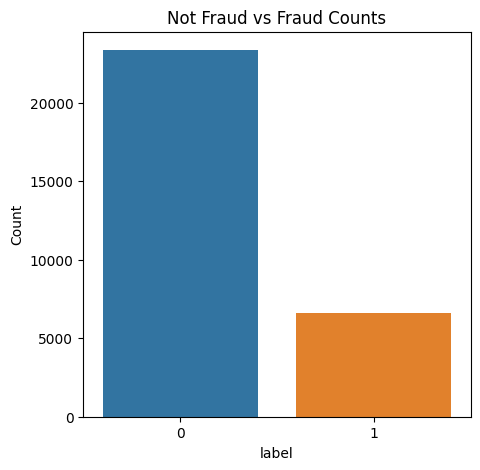

In [10]:
#check the fraud proportion of the data
target_info(data['label'])

In [11]:
# set an exclude list for the scorecard package Toad
exclude_list = ['ID','label']

In [12]:
data.ID.describe()

count    30000.000000
mean     15000.500000
std       8660.398374
min          1.000000
25%       7500.750000
50%      15000.500000
75%      22500.250000
max      30000.000000
Name: ID, dtype: float64

In [13]:
# use the ID column to split the train-test data
train = data_split(data,start = 0, end=22500,date_col='ID')
test = data_split(data,start = 22500, end=172792,date_col='ID')

In [14]:
train.label.value_counts()

label
0    17411
1     5088
Name: count, dtype: int64

In [15]:
test.label.value_counts()

label
0    5953
1    1548
Name: count, dtype: int64

## Feature Filtering

* feature filtering by missing value, IV & corrrelation：
* If the missing value rate is greater than the threshold, delete the feature
* If the correlation coefficient is greater than the threshold, delete the feature
* If the IV is smaller than the threshold, delete the features

In [16]:

train_selected, drop_lst= toad.selection.select(frame = train,
                                                target=train['label'], 
                                                empty = 0.7, 
                                                iv = 0.02, corr = 1, 
                                                return_drop=True, 
                                                exclude=exclude_list)
print("keep:",train_selected.shape[1],
      "drop empty:",len(drop_lst['empty']),
      "drop iv:",len(drop_lst['iv']),
      "drop corr:",len(drop_lst['corr']))


keep: 23 drop empty: 0 drop iv: 2 drop corr: 0


In [17]:
drop_lst

{'empty': array([], dtype=float64),
 'iv': array(['SEX', 'MARRIAGE'], dtype=object),
 'corr': array([], dtype=object)}

In [18]:
# output the iv table to a dataframe
def output_iv_importance(train_selected,label_col):
    feat_import_iv = toad.quality(train_selected,label_col,iv_only=True)
    feat_import_iv=feat_import_iv['iv']
    feat_import_iv = feat_import_iv.reset_index()
    feat_import_iv.columns = ['name','iv']
    return feat_import_iv
df_iv=output_iv_importance(train_selected,'label')

In [20]:
df_iv.head(10)

,name,iv
0,PAY_0,0.864707
1,PAY_2,0.536068
2,PAY_3,0.401513
3,PAY_4,0.349813
4,PAY_5,0.340014
5,PAY_6,0.282692
6,PAY_AMT1,0.189334
7,LIMIT_BAL,0.170973
8,PAY_AMT2,0.168256
9,PAY_AMT3,0.128827


## Feature Binning

#### Feature binning is to transform a continuous or numerical variable into a categorical feature.
* It simplifies the logistic regression model and reduces the risk of model overfitting
* Logistic regression is a generalized linear model, and its expressive ability is limited; Feature binning can introduce nonlinearity into the model, which can improve the expressive ability of the model and help better model fitting
* The discretized features are very robust to abnormal data: for example, a feature is 1 if age > 30, and 0 otherwise. If the features are not discretized, an abnormal data point "300 years old" will impact the model fitting
* It can treat null data as an individual class

In [21]:
train_selected.label.value_counts()

label
0    17411
1     5088
Name: count, dtype: int64

In [22]:
train_selected.shape

(22499, 23)

### Steps for Feature binning:
#### Step 1. Initialization: c = toad.transform.Combiner() 
#### Step 2. Training binning: 
c.fit(dataframe, 
      y = 'target', 
      method = 'chi', 
      min_samples = 0.05, 
      n_bins = None, 
      empty_separate = False)

* y: target column
* method: binning method, supports chi (chi-square binning), dt (decision tree binning), kmean, quantile, step (equal step size binning)
* min_samples: Each box contains the least number of samples, which can be a number or a proportion 
* n_bins: the number of bins; If it is not possible to divide so many boxes the maximum number of bins will be divided.
* empty_separate: Whether to separate empty boxes separately 

#### Step 3. check binning nodes: c.export() 
#### Step 4. Manually adjust binning: c.load(dict) 
#### Step 5. Apply binning results: c.transform(dataframe, labels=False)

* labels: Whether to convert the binning results into box labels. If False, output 0, 1, 2… (discrete variables are sorted according to the proportion), and if True output (-inf, 0], (0,10], (10, inf).

In [23]:
import time
start = time.time()
combiner = toad.transform.Combiner()
# use the filtered features for training
# Use the stable chi-square binning, 
# specifying that each bin has at least 5% data to ensure stability
# empty values will be automatically assigned to the best bin
combiner.fit(X=train_selected,
             y=train_selected['label'],
             method='chi',
             min_samples = 0.05,
             exclude=exclude_list)
end = time.time()
print((end-start)/60)

1.6967908302942911


In [24]:
combiner

In [25]:
# save 1: pickle combiner
filename = 'CreditScore_save1_combiner.pkl'
pickle.dump(combiner, open(filename, 'wb'))

In [26]:
filename

'CreditScore_save1_combiner.pkl'

In [27]:
#output binning
bins = combiner.export()

In [28]:
len(bins)

21

In [30]:
bins

{'LIMIT_BAL': [50000.0,
  60000.0,
  80000.0,
  110000.0,
  150000.0,
  230000.0,
  370000.0],
 'EDUCATION': [2],
 'AGE': [26, 29, 34, 46],
 'PAY_0': [-1, 0, 1, 2],
 'PAY_2': [-1, 2],
 'PAY_3': [-1, 0, 2],
 'PAY_4': [-1, 0, 1],
 'PAY_5': [-1, 0, 2],
 'PAY_6': [-1, 0, 2],
 'BILL_AMT1': [2501.0],
 'BILL_AMT2': [2400.0, 8287.0, 35213.0],
 'BILL_AMT3': [2400.0, 7458.0, 81890.0],
 'BILL_AMT4': [2501.0],
 'BILL_AMT5': [2395.0, 8110.0, 35288.0],
 'BILL_AMT6': [19195.0, 50442.0],
 'PAY_AMT1': [6.0, 4902.0],
 'PAY_AMT2': [92.0, 1603.0, 4520.0, 15002.0],
 'PAY_AMT3': [1.0, 2921.0],
 'PAY_AMT4': [1.0, 1506.0, 3946.0],
 'PAY_AMT5': [1.0, 1880.0, 10000.0],
 'PAY_AMT6': [28.0, 480.0, 926.0, 1078.0, 1501.0, 4060.0, 9567.0]}

In [31]:
#apply binning
train_selected_bin = combiner.transform(train_selected)
test_bin = combiner.transform(test[train_selected_bin.columns])

In [32]:
train_selected_bin.head()

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,1,0,1,0,4,2,1,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,2,4,1,1,1,2,2,2,2,3,...,1,1,0,0,1,1,1,0,5,1
2,3,3,1,3,2,1,2,2,2,2,...,1,2,0,1,1,1,1,1,6,0
3,4,1,1,3,2,1,2,2,2,2,...,1,2,1,1,2,1,1,1,3,0
4,5,1,1,4,1,1,1,2,2,2,...,1,2,0,1,4,2,3,1,2,0


In [33]:
features_list = [feat for feat in train_selected_bin.columns if feat not in exclude_list]
len(features_list)

21

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

<Axes: xlabel='PAY_AMT1', ylabel='prop'>

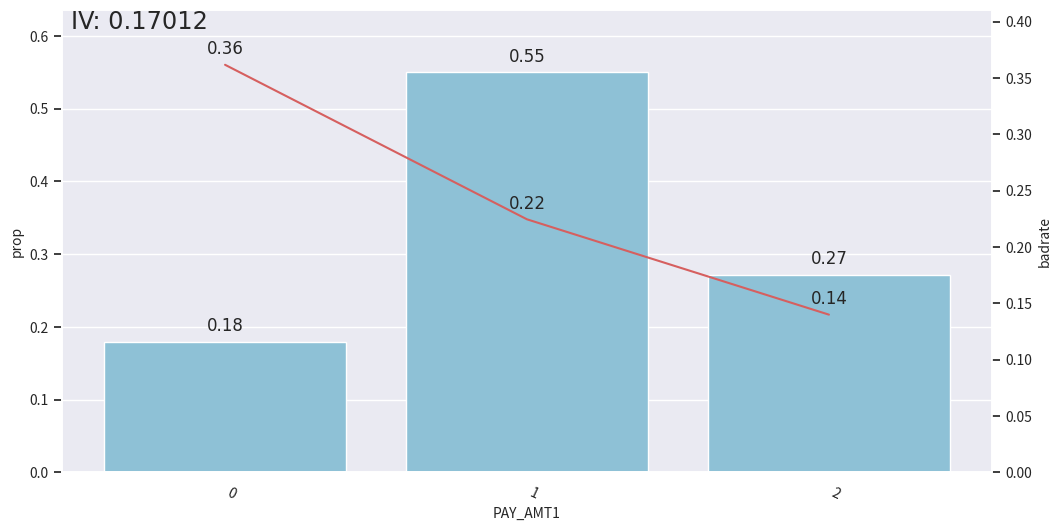

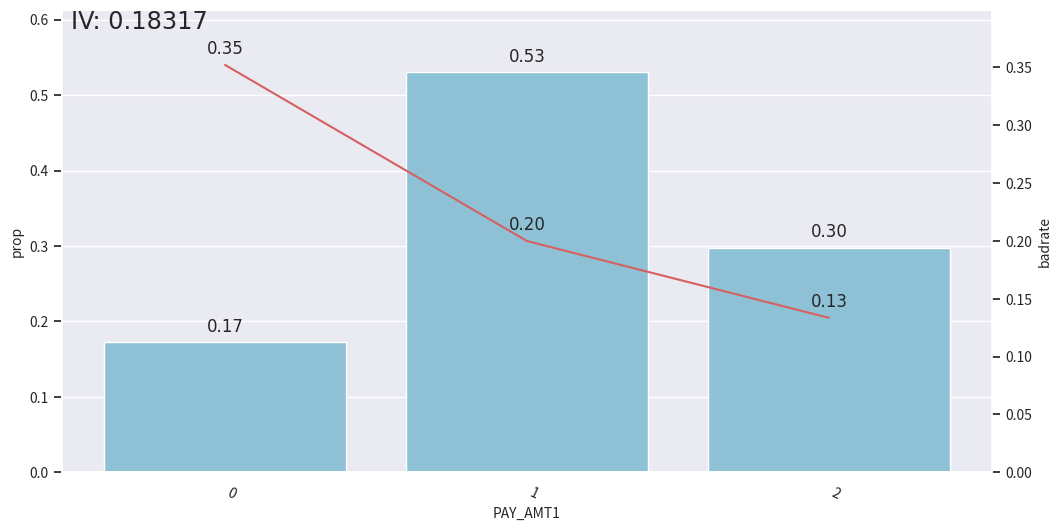

In [34]:
#Fine tune bins
from toad.plot import  bin_plot,badrate_plot
bin_plot(train_selected_bin,x='PAY_AMT1',target='label')
bin_plot(test_bin,x='PAY_AMT1',target='label')

In [35]:
train_selected_bin.PAY_0.describe()

count    22499.000000
mean         1.988711
std          1.038531
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: PAY_0, dtype: float64

## Transform to WOE

* **Weight of Evidence (WoE)** is a statistical technique used in credit risk assessment to measure how well a group of attributes can predict a desired outcome

In [36]:
#WOE
t=toad.transform.WOETransformer()
#transform training set
train_woe = t.fit_transform(X=train_selected_bin,
                            y=train_selected_bin['label'], 
                            exclude=exclude_list)
#transform testing set
test_woe = t.transform(test_bin)

In [37]:
train_woe.head()

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,1,0.666522,0.089338,0.260065,2.019269,1.459809,-0.417749,-0.383479,-0.146325,-0.117947,...,0.028510,-0.006521,-0.034304,0.662394,0.124160,0.488183,0.454327,0.370272,0.343887,1
1,2,-0.034630,0.089338,-0.100163,-0.308169,1.459809,-0.296556,-0.230510,-0.203587,1.282840,...,-0.009858,-0.239312,-0.034304,0.662394,0.124160,0.016060,0.056501,0.370272,-0.082401,1
2,3,0.108342,0.089338,-0.028816,-0.677822,-0.408118,-0.296556,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,-0.034304,-0.009085,0.124160,0.016060,0.056501,0.084926,-0.391360,0
3,4,0.200392,0.089338,-0.028816,-0.677822,-0.408118,-0.296556,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,0.162615,-0.009085,-0.076846,0.016060,0.056501,0.084926,-0.119586,0
4,5,0.200392,0.089338,0.156679,-0.308169,-0.408118,-0.417749,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,-0.034304,-0.009085,-1.078550,-0.372758,-0.457199,0.084926,0.257636,0


In [38]:
final_data_woe = pd.concat([train_woe,test_woe])

In [39]:
#save 2: pickle woe_transform
filename = 'CreditScore_save2_woe_transform.pkl'
pickle.dump(t, open(filename, 'wb'))

In [40]:
features_use = [feat for feat in final_data_woe.columns if feat not in exclude_list]

In [41]:
len(features_use)

21

## Calculate PSI

* **PSI (Population Stability Index)** reflects the stability of the distribution. We often use it to screen features and evaluate model stability. The industry level is to drop features with a PSI greater than **0.2**

In [47]:
#get the feature name
features_list = [feat for feat in train_woe.columns if feat not in exclude_list]
#calculate PSI using toad
psi_df = toad.metrics.PSI(train_woe[features_list], test_woe[features_list]).sort_values()
#put into a dataframe
psi_df = psi_df.reset_index()
psi_df = psi_df.rename(columns = {'index' : 'feature',0:'psi'})

In [49]:
psi_df.head()

,feature,psi
0,EDUCATION,0.000258
1,BILL_AMT4,0.000330
2,BILL_AMT6,0.001591
3,BILL_AMT5,0.002520
4,BILL_AMT1,0.002634


In [50]:
# features less than 0.25
psi025 = list(psi_df[psi_df.psi<0.25].feature)
# features geater than 0.25
psi_remove = list(psi_df[psi_df.psi>=0.25].feature)

In [51]:
psi_remove

[]

In [52]:
# keep exclude list
for i in exclude_list:
    if i in psi025:
        pass
    else:
       psi025.append(i) 

In [53]:
# remove features that are geater than 0.25
train_selected_woe_psi = train_woe[psi025]
off_woe_psi = test_woe[psi025]

In [54]:
# output our final data table
final_data_woe = pd.concat([train_selected_woe_psi,off_woe_psi])

In [55]:
print(final_data_woe.shape)

(30000, 23)


In [56]:
#save 3: final data table with transformed woe
final_data_woe.to_csv('CreditScore_save3_final_data_woe.csv')

## Output IV

In [57]:
features_use = [feat for feat in final_data_woe.columns if feat not in exclude_list]
len(features_use)

21

In [58]:
df_iv=output_iv_importance(final_data_woe[features_use+['label']],'label')

In [60]:
df_iv.head()

,name,iv
0,PAY_0,0.873565
1,PAY_2,0.546857
2,PAY_3,0.412420
3,PAY_4,0.359289
4,PAY_5,0.333734


In [61]:
#save 4: information value after woe transformation
df_iv.to_csv('CreditScore_save4_IV.csv')

## Model Tuning

In [76]:
#Function to check train_test
def check_train_test_auc(x_train,y_train,x_test,y_test):
    
    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression(random_state=42,C= 0.1, penalty='l2', solver='newton-cg')


    lr = LogisticRegression(class_weight='balanced')
    lr.fit(x_train, y_train)

    
    pred_train = lr.predict_proba(x_train)[:,1]
    from toad.metrics import KS, AUC

    print('train KS',KS(pred_train, y_train))
    print('train AUC',AUC(pred_train, y_train))
    
    pred_OOT =lr.predict_proba(x_test)[:,1]
    print('Test KS',KS(pred_OOT, y_test))
    print('Test AUC',AUC(pred_OOT, y_test))
    
    from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay, classification_report

    #from sklearn.metrics import RocCurveDisplay
    fig, ax = plt.subplots(figsize=(12, 8))
    RocCurveDisplay.from_estimator(lr, x_test, y_test, color='blue', ax=ax)

## Logistic Regression

train KS 0.40988185783295383
train AUC 0.7703231409316528
Test KS 0.4264763906414198
Test AUC 0.7834659071425564


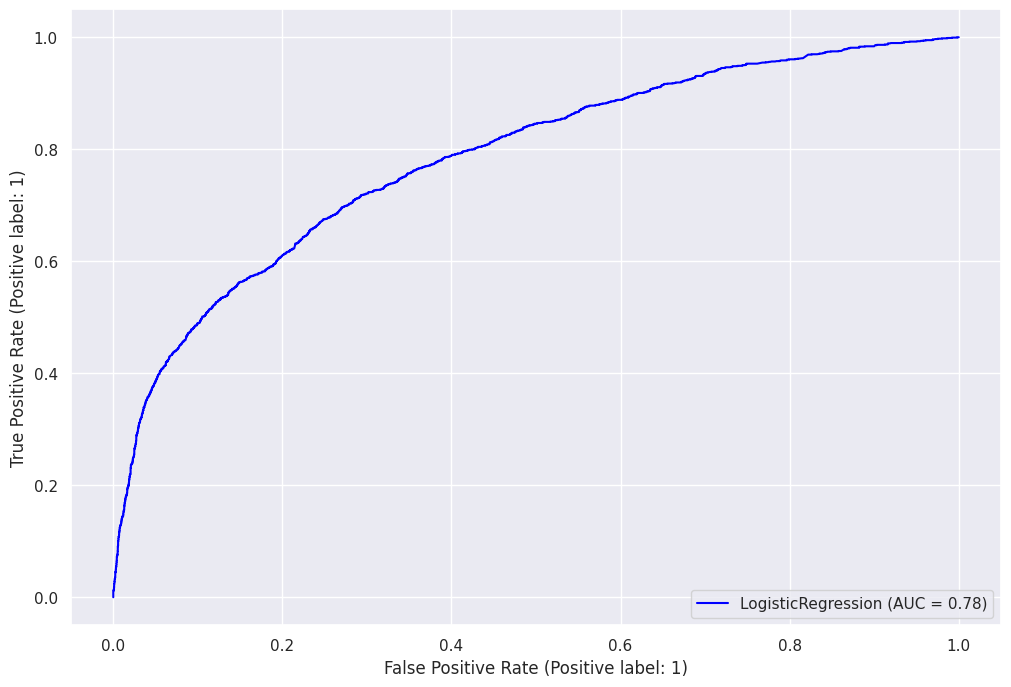

In [77]:
#train & test
check_train_test_auc(x_train = train_woe[features_use],y_train=train_woe['label'],
                     x_test =test_woe[features_use] ,y_test = test_woe['label'])

## GBDT Model

#### Train a GBDT and check the feature importance table

* **Gradient-boosted decision trees (GBDT)** are a popular method for solving prediction problems in both classification and regression domains. The approach improves the learning process by simplifying the objective and reducing the number of iterations to get to a sufficiently optimal solution.

In [85]:
def get_evaluation_scores(label, predictions):
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.metrics import balanced_accuracy_score
    tp, fn, fp, tn = confusion_matrix(label,predictions,labels=[1,0]).reshape(-1)
    print('True Positive：',tp)
    print('True Negative：',tn)
    print('False Positive：',fp)
    print('False Negative：',fn)
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    print('accuracy: ',accuracy)
    recall = tp/(tp+fn)
    print('（recall）: ',recall)
    precision = tp/(tp+fp)
    print('（precision）: ',precision)
    #f1 score = 2*(P*R)/(P+R)
    f1 = 2*precision*recall/(precision+recall)
    print('F1 score: ',f1)
    
    print(classification_report(label, predictions))
    
    print('balanced_accuracy_score: ',balanced_accuracy_score(label,predictions))
    return precision, recall

def evaluate_result(df_train,df_test,features_name):
    from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
    import seaborn as sns
    import matplotlib.pyplot as plt
    start = time.time()
    x_train = df_train[features_name]
    y_train = df_train['label']

    x_test  = df_test[features_name]
    y_test  = df_test['label']

    model = GradientBoostingClassifier(n_estimators=250,random_state=0)
    model.fit(x_train,y_train)
    predictions = model.predict(x_test)
    get_evaluation_scores(label = y_test, predictions=predictions)
    feat_importances = pd.Series(model.feature_importances_, index=features_name)
    feat_importances=pd.DataFrame(feat_importances).reset_index()
    feat_importances.columns=['feature_name','feature_importance']
    feat_importances=feat_importances.sort_values(['feature_importance'],ascending=False)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15,15))

    sns_plot1=sns.barplot(feat_importances.feature_importance,estimator=sum)#feat_importances.feature_name,
    plt.title("Features Importance",size=18)
    plt.ylabel('', size = 15)
    plt.tick_params(labelsize=18)
    return feat_importances,model,x_train,y_train,x_test,y_test

True Positive： 542
True Negative： 5725
False Positive： 228
False Negative： 1006
accuracy:  0.8354886015197973
（recall）:  0.35012919896640826
（precision）:  0.7038961038961039
F1 score:  0.46764452113891286
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      5953
           1       0.70      0.35      0.47      1548

    accuracy                           0.84      7501
   macro avg       0.78      0.66      0.69      7501
weighted avg       0.82      0.84      0.81      7501

balanced_accuracy_score:  0.6559145910840776


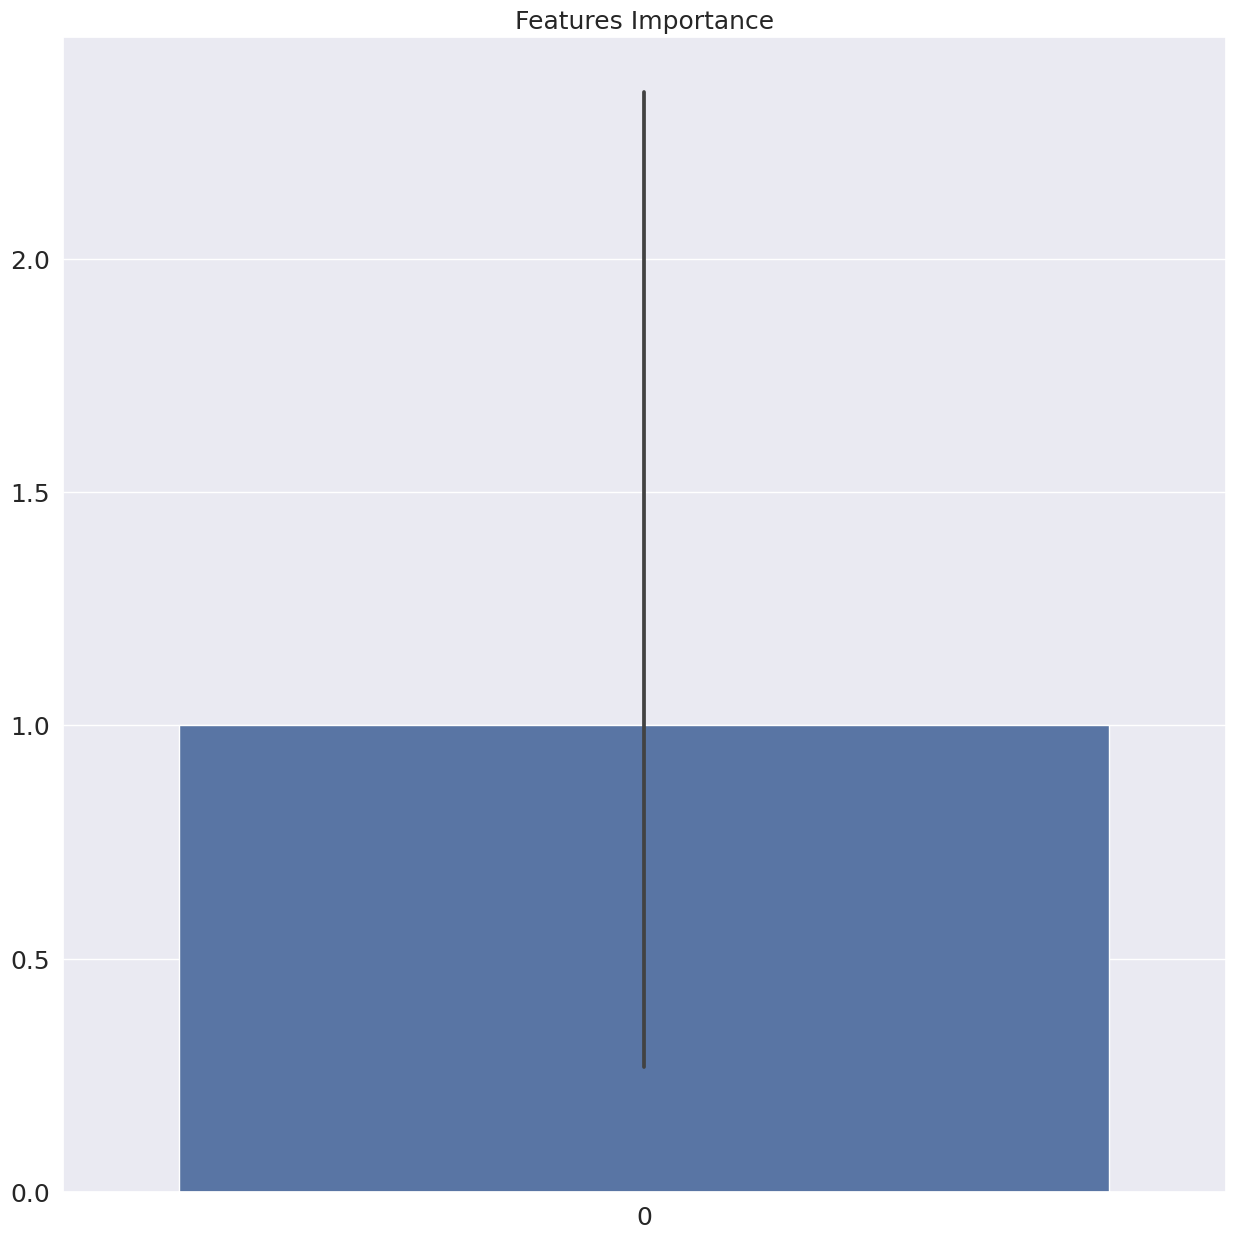

In [86]:
fet_importance_GBDT_reason,model,x_train,y_train,x_test,y_test = evaluate_result(df_train=train_woe,
                df_test=test_woe,
                features_name=features_use)

In [87]:
fet_importance_GBDT_reason

,feature_name,feature_importance
19,PAY_0,0.641879
14,PAY_2,0.080198
13,PAY_3,0.044386
17,LIMIT_BAL,0.030078
11,PAY_AMT2,0.028890
15,PAY_5,0.027666
12,PAY_4,0.023903
18,PAY_6,0.019000
6,PAY_AMT1,0.018523
9,PAY_AMT6,0.017613


In [88]:
def plot_roc_pre_recall_curve(labels, probs):
    from sklearn.metrics import precision_recall_curve
    # Get ROC curve FPR and TPR from true labels vs score values
    fpr, tpr, _ = roc_curve(labels, probs)

    # Calculate ROC Area Under the Curve (AUC) from FPR and TPR data points
    roc_auc = auc(fpr, tpr)

    # Calculate precision and recall from true labels vs score values
    precision, recall, _ = precision_recall_curve(labels, probs)

    plt.figure(figsize=(8, 3))

    plt.subplot(1,2,1)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.step(recall, precision, color='orange', where='post')
    # plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision Recall Curve')
    plt.grid(True)

    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure 
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.5   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
    plt.show()

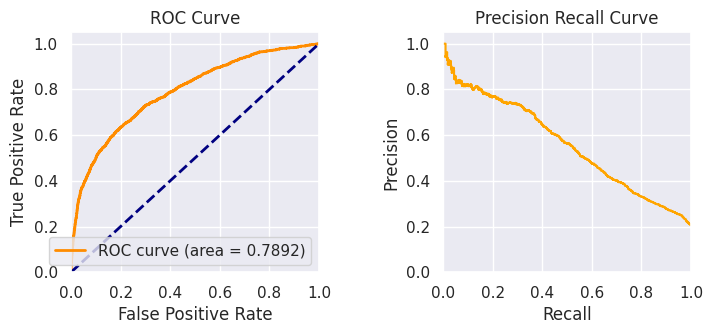

In [89]:
probs = model.predict_proba(x_test)[:,1]
sns.set(font_scale = 1)
plot_roc_pre_recall_curve(y_test, probs)

## Model Production

In [90]:
#prepare train & test data
x_train = train_woe[features_use]
y_train=train_woe['label']
x_test =test_woe[features_use] 
y_test = test_woe['label']

In [91]:
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(x_train, y_train)

LogisticRegression(class_weight='balanced')

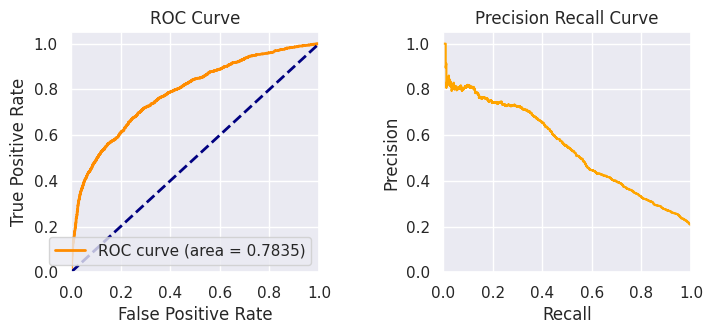

In [92]:
#check AUC
probs = lr.predict_proba(x_test)[:,1]
sns.set(font_scale = 1)
plot_roc_pre_recall_curve(y_test, probs)

## Scorecard Generation

In [93]:
# scorecard tuning
card = toad.ScoreCard(
    combiner = combiner,
    transer = t,
    class_weight = 'balanced',
    C=0.1,
    base_score = 1000,
    base_odds = 35 ,
    pdo = 80,
    rate = 2
)

card.fit(train_woe[features_use], train_woe['label'])

ScoreCard(base_score=1000,
          combiner=<toad.transform.Combiner object at 0x7d15cac8b880>, pdo=80,
          transer=<toad.transform.WOETransformer object at 0x7d15ca7d8b20>)

In [94]:
# save 5: save the model to disk
filename = 'CreditScore_save5_ScoreCard.pkl'
pickle.dump(card, open(filename, 'wb'))

In [95]:
#inference on test data
test['CreditScore'] = card.predict(test)
test['CreditScore'].describe()

count    7501.000000
mean      627.437143
std       113.055983
min       173.540655
25%       596.974091
50%       659.897345
75%       702.107780
max       810.644058
Name: CreditScore, dtype: float64

In [96]:
#inference on whole data
data['CreditScore'] = card.predict(data)
data['CreditScore'].describe()

count    30000.000000
mean       617.559238
std        118.265235
min        168.851703
25%        578.204047
50%        654.175758
75%        696.461008
max        818.460370
Name: CreditScore, dtype: float64

In [97]:
#output the scorecard
final_card_score=card.export()
len(final_card_score)

21

In [101]:
#transform the scorecard into dataframe and save to csv
keys = list(card.export().keys())
score_card_df = pd.DataFrame()
for n in keys:
    temp = pd.DataFrame.from_dict(final_card_score[n], orient='index')
    temp = temp.reset_index()
    temp.columns= ['binning','score']
    temp['variable'] = n
    temp = temp[['variable','binning','score']]
    score_card_df= pd.concat([score_card_df, pd.DataFrame(temp)], ignore_index=True)
score_card_df.head(30)

,variable,binning,score
0,EDUCATION,[-inf ~ 2),29.66
1,EDUCATION,[2 ~ inf),27.20
2,BILL_AMT4,[-inf ~ 2501.0),28.21
3,BILL_AMT4,[2501.0 ~ inf),27.97
4,BILL_AMT6,[-inf ~ 19195.0),27.33
5,BILL_AMT6,[19195.0 ~ 50442.0),31.37
6,BILL_AMT6,[50442.0 ~ inf),26.23
7,BILL_AMT5,[-inf ~ 2395.0),28.16
8,BILL_AMT5,[2395.0 ~ 8110.0),32.85
9,BILL_AMT5,[8110.0 ~ 35288.0),25.20


In [102]:
#save 6: save the scorcard
score_card_df.to_csv('CreditScore_save6_score_card_df.csv',index=False)

## Distribution Analysis

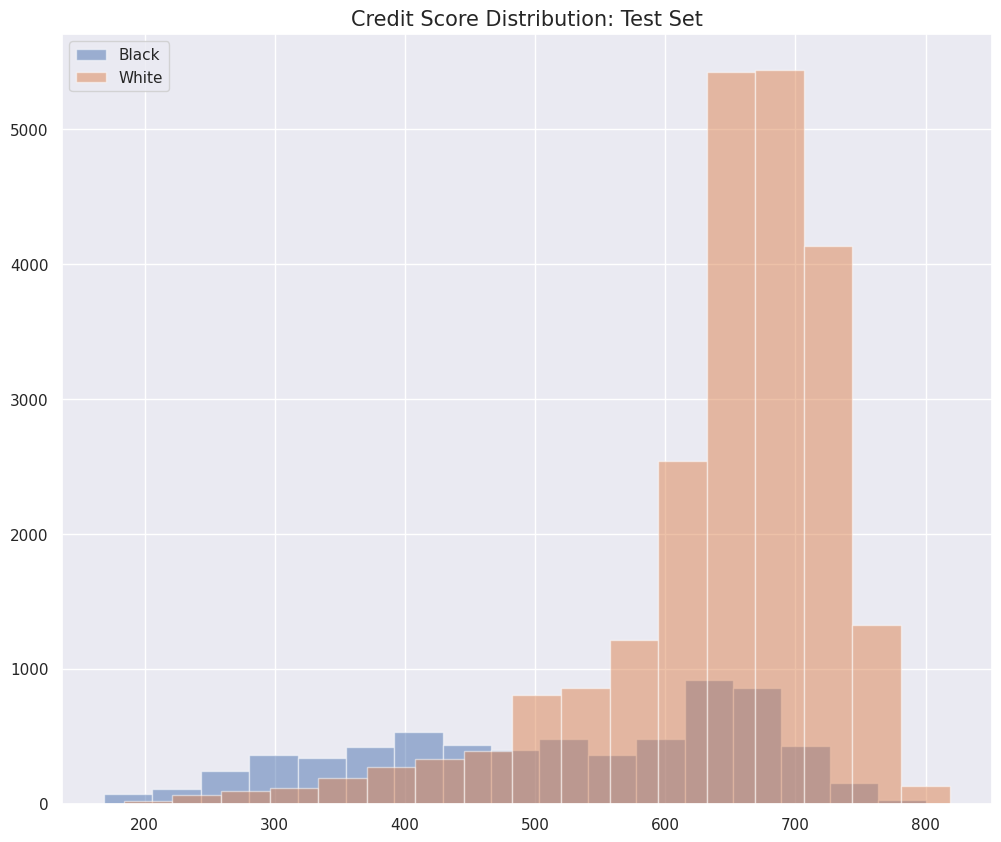

In [103]:
plt.figure(figsize=(12,10))
import random
import numpy
from matplotlib import pyplot as plt

w = 40
n = math.ceil((data['CreditScore'].max() - data['CreditScore'].min())/w)
#bins = numpy.linspace(-10, 10, 100)

plt.hist(data[data.label==1].CreditScore, alpha=0.5, label='Black',bins = n)
plt.hist(data[data.label==0].CreditScore, alpha=0.5, label='White',bins = n)
plt.legend(loc='upper left')
plt.title('Credit Score Distribution: Test Set',size=15)
plt.show()

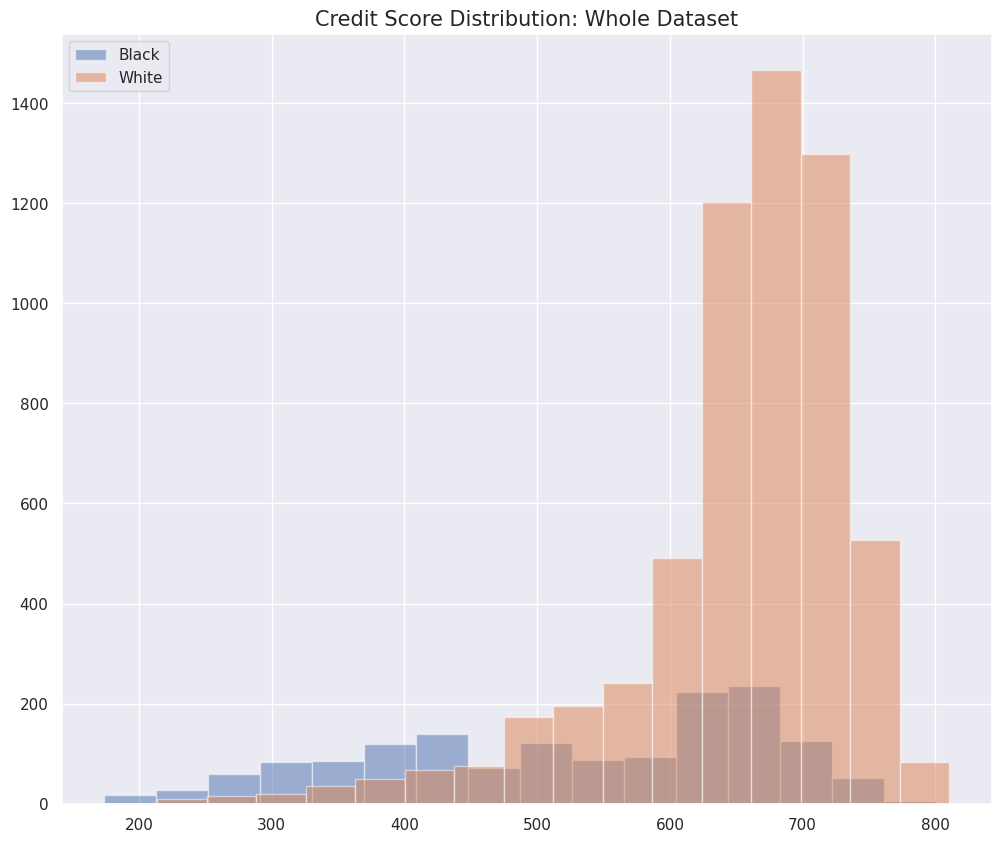

In [104]:
plt.figure(figsize=(12,10))
import random
import numpy
from matplotlib import pyplot as plt

w = 40
n = math.ceil((test['CreditScore'].max() - test['CreditScore'].min())/w)
#bins = numpy.linspace(-10, 10, 100)

plt.hist(test[test.label==1].CreditScore, alpha=0.5, label='Black',bins = n)
plt.hist(test[test.label==0].CreditScore, alpha=0.5, label='White',bins = n)
plt.legend(loc='upper left')
plt.title('Credit Score Distribution: Whole Dataset',size=15)
plt.show()

## Threshold Tuning

In [105]:
def get_credit_level(
    test,
    target_score ='order_score',
    out_col = 'order_level',
    left_bound = -100,
    level_0 = 100,
    level_1 = 200,    
    level_2 = 250,    
    level_3 = 300,    
    level_4 = 350,    
    level_5 = 400,    
    level_6 = 450,
    level_7 = 500,
    level_8 = 800):
    level = []
    for i in range(len(test)):
        if (test[target_score][i]>left_bound) & (test[target_score][i]<=level_0):
            level.append(0)
        elif  (test[target_score][i]>level_0) & (test[target_score][i]<=level_1):
            level.append(1)
        elif  (test[target_score][i]>level_1) & (test[target_score][i]<=level_2):
            level.append(2)
        elif  (test[target_score][i]>level_2) & (test[target_score][i]<=level_3):
            level.append(3)
        elif  (test[target_score][i]>level_3) & (test[target_score][i]<=level_4):
            level.append(4)
        elif  (test[target_score][i]>level_4) & (test[target_score][i]<=level_5):
            level.append(5)
        elif  (test[target_score][i]>level_5) & (test[target_score][i]<=level_6):
            level.append(6)
        elif  (test[target_score][i]>level_6) & (test[target_score][i]<=level_7):
            level.append(7)
        elif  (test[target_score][i]>level_7 )& (test[target_score][i]<=level_8):
            level.append(8)
        
    test[out_col] = level
    return test

def plot_bts_level_loss(test, target_col):
    bts_level_df = test[target_col].value_counts()
    bts_level_df=pd.DataFrame(bts_level_df)
    df_label_level= test[test.label==1].groupby(target_col)['label'].count()/ test.groupby(target_col)['label'].count()
    df_label_level = pd.DataFrame(df_label_level)
    bts_level_df.sort_index().plot.bar(title='')
    df_label_level.plot()

In [106]:
test.CreditScore.describe()

count    7501.000000
mean      627.437143
std       113.055983
min       173.540655
25%       596.974091
50%       659.897345
75%       702.107780
max       810.644058
Name: CreditScore, dtype: float64

## Threshold Tuning & Trade-off between loss & Coverage

In [107]:
test = get_credit_level(test,
                       target_score ='CreditScore',
                       out_col = 'CreditScore_level',
                      left_bound = -1000,
    level_0 = 250,
    level_1 = 300,    
    level_2 = 400,    
    level_3 = 500,    
    level_4 = 580,    
    level_5 = 630,    
    level_6 = 690,
    level_7 = 730,
    level_8 = 1000
                )

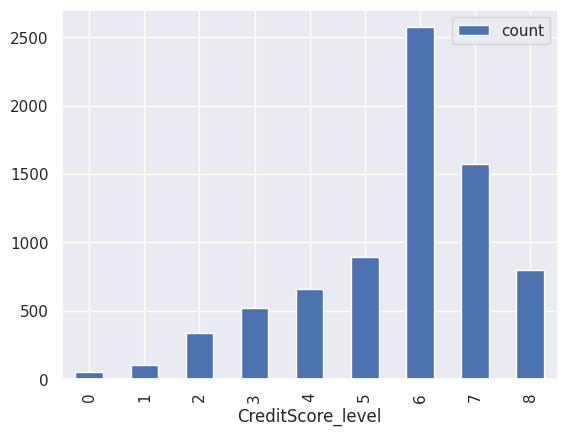

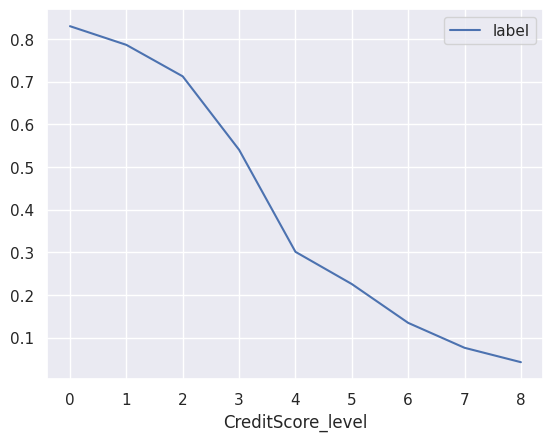

In [108]:
plot_bts_level_loss(test,target_col='CreditScore_level')

In [109]:
sum(test[test.label==1].CreditScore_level==7)

120

In [110]:
def get_loss_coverage(test,target_level):
    
    #level 8 Loss
    L8_loss=test[test[target_level]>=8 ].label.value_counts()/len(test[test[target_level]>=8 ])
    #level 8 Coverage
    L8_coverage=test[test[target_level]>=8].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 8: Loss is ",L8_loss[1], "; Coverage is ",L8_coverage)
    
    #level 7-level 8 Loss
    L7_loss=test[test[target_level]>=7 ].label.value_counts()/len(test[test[target_level]>=7 ])
    #level 7-level 8 Coverage
    L7_coverage=test[test[target_level]>=7].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 7-Level 8: Loss is ",L7_loss[1], "; Coverage is ",L7_coverage)
    
    #level 6-level 8 Loss
    L6_loss=test[test[target_level]>=6 ].label.value_counts()/len(test[test[target_level]>=6 ])
    #level 6-level 8 Coverage
    L6_coverage=test[test[target_level]>=6].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 6-Level 8: Loss is ",L6_loss[1], "; Coverage is ",L6_coverage)
    
     #level 5-Leve 8 Loss (percentage of default people)
    L5_loss = test[test[target_level]>=5 ].label.value_counts()/len(test[test[target_level]>=5 ])
    #level 5- level 8 Coverage (percentage of good people)
    L5_coverage=test[test[target_level]>=5 ].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 5-Level 8: Loss is ",L5_loss[1], "; Coverage is ",L5_coverage)
    
    #level 4-level 8 Loss
    L4_loss=test[test[target_level]>=4 ].label.value_counts()/len(test[test[target_level]>=4 ])
    #level 4-level 8 Coverage
    L4_coverage=test[test[target_level]>=4].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 4-Level 8: Loss is ",L4_loss[1], "; Coverage is ",L4_coverage)
    
    
    #level 3-level 8 Loss
    L3_loss=test[test[target_level]>=3].label.value_counts()/len(test[test[target_level]>=3 ])
    #level 3-level 8 Coverage
    L3_coverage=test[test[target_level]>=3].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 3-Level 8: Loss is ",L3_loss[1], "; Coverage is ",L3_coverage)
    
    #level 2-level 8 Loss
    L2_loss=test[test[target_level]>=2].label.value_counts()/len(test[test[target_level]>=2 ])
    #level 2-level 8 Coverage
    L2_coverage=test[test[target_level]>=2].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 2-Level 8: Loss is ",L2_loss[1], "; Coverage is ",L2_coverage)
    
    #level 1-level 8 Loss
    L1_loss=test[test[target_level]>=1].label.value_counts()/len(test[test[target_level]>=1 ])
    #level 1-level 8 Coverage
    L1_coverage=test[test[target_level]>=1].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 1-Level 8: Loss is ",L1_loss[1], "; Coverage is ",L1_coverage)
    
    #level 0-level 8 Loss
    L0_loss=test[test[target_level]>=0].label.value_counts()/len(test[test[target_level]>=0 ])
    #level 0-level 8 Coverage
    L0_coverage=test[test[target_level]>=0].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 0-Level 8: Loss is ",L0_loss[1], "; Coverage is ",L0_coverage)

In [111]:
get_loss_coverage(test,target_level='CreditScore_level')

Level 8: Loss is  0.04271356783919598 ; Coverage is  0.12800268772047707
Level 7-Level 8: Loss is  0.0650887573964497 ; Coverage is  0.3715773559549807
Level 6-Level 8: Loss is  0.10143753796315043 ; Coverage is  0.745506467327398
Level 5-Level 8: Loss is  0.1204323211528564 ; Coverage is  0.8612464303712414
Level 4-Level 8: Loss is  0.13876040703052728 ; Coverage is  0.938350411557198
Level 3-Level 8: Loss is  0.1684751570531125 ; Coverage is  0.97833025365362
Level 2-Level 8: Loss is  0.19373723621511232 ; Coverage is  0.9947925415756761
Level 1-Level 8: Loss is  0.20193340494092374 ; Coverage is  0.9984881572316479
Level 0-Level 8: Loss is  0.20637248366884414 ; Coverage is  1.0


In [112]:
#save 7: save the scorcard
data.to_csv('OrderScore_save7_whole_data.csv',index=False)

In [113]:
card.predict(test)[0]

751.3301912707651

## **Observations**

Throughout the project, the following key observations were made:

#### Feature Engineering and Data Stability:

* Feature filtering and binning significantly enhanced the interpretability and predictive power of the model.
* Transforming features into Weight of Evidence (WOE) format facilitated the linear relationship with the log-odds of default, aligning with credit scorecard requirements.
* PSI calculation revealed that certain features experienced drift over time, requiring adjustments to maintain model stability.

#### Model Performance:

* Logistic regression provided a straightforward and interpretable model, with coefficients directly influencing scorecard points.
* The GBDT model outperformed logistic regression in terms of raw predictive accuracy but required additional steps for explainability and integration into a scorecard framework.

#### Scorecard Generation:

* Converting model outputs into a scorecard format simplified communication with stakeholders and aligned with business requirements.
* The scorecard’s distribution analysis demonstrated a reasonable separation between good and bad credit risks, ensuring practical usability.

#### Threshold Tuning and Trade-offs:

* Optimizing the decision threshold involved balancing loss (from misclassified defaulters) and coverage (total loans approved).
* A lower threshold increased coverage but posed a higher risk of defaults, while a higher threshold minimized losses at the cost of reduced loan approvals.

#### Business Insights:

* The trade-off analysis highlighted the need for business-driven threshold selection based on risk appetite and operational constraints.
* Scorecard visualization and interpretation played a vital role in gaining stakeholder trust and ensuring regulatory compliance.


## **Conclusion**

This project successfully developed an **end-to-end framework** for building a credit scorecard using machine learning techniques. By following a structured approach to feature engineering, model development, and evaluation, the final solution achieved a balance between accuracy, interpretability, and practicality.

The integration of traditional statistical methods like logistic regression with modern machine learning techniques, such as GBDT, enhanced model performance while ensuring compliance with industry standards. Scorecard generation and threshold tuning addressed real-world business challenges, providing actionable insights for risk management.

This guide demonstrates that combining domain knowledge with advanced analytics can significantly improve decision-making in credit risk assessment. Future enhancements could include incorporating alternative data sources, employing more sophisticated explainability tools, and automating updates to ensure ongoing model relevance and stability.

Prepared by - **Karthikeya Valmiki**

Date created - 18-06-2023

Date modified - 16-11-2024